## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [510]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import scipy
from scipy import signal
from collections import deque
%matplotlib inline

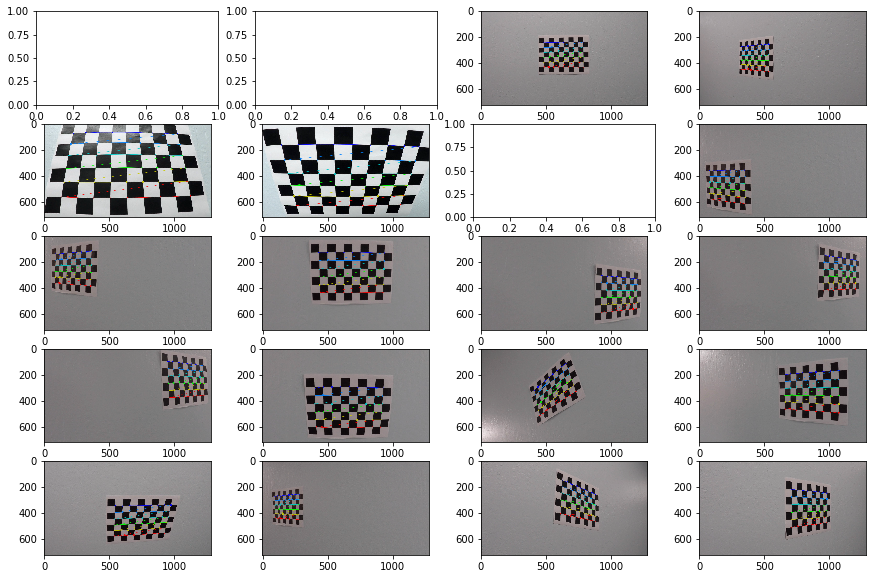

In [511]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Set matplotlib parameters
# revel: 
f, ax = plt.subplots(5, 4, figsize=(15, 10))
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Draw and display the corners
        img = Image.fromarray(img, 'RGB')
        ax[i].imshow(img)
        #print('DONE')
    #else:
        #print('ERROR')

In [512]:
# numpy.ravel() method
test_1 = np.array([[1, 2 ], [3, 4, 5]])
print('array')
print(test_1)
print('success rabeled')
print(np.ravel(test_1))

test_2 = np.array([[1, 2, 6], [3, 4, 5]])
print('array')
print(test_2)
print('success rabeled')
print(np.ravel(test_2))

array
[list([1, 2]) list([3, 4, 5])]
success rabeled
[list([1, 2]) list([3, 4, 5])]
array
[[1 2 6]
 [3 4 5]]
success rabeled
[1 2 6 3 4 5]


## Apply a distortion correction to raw images.

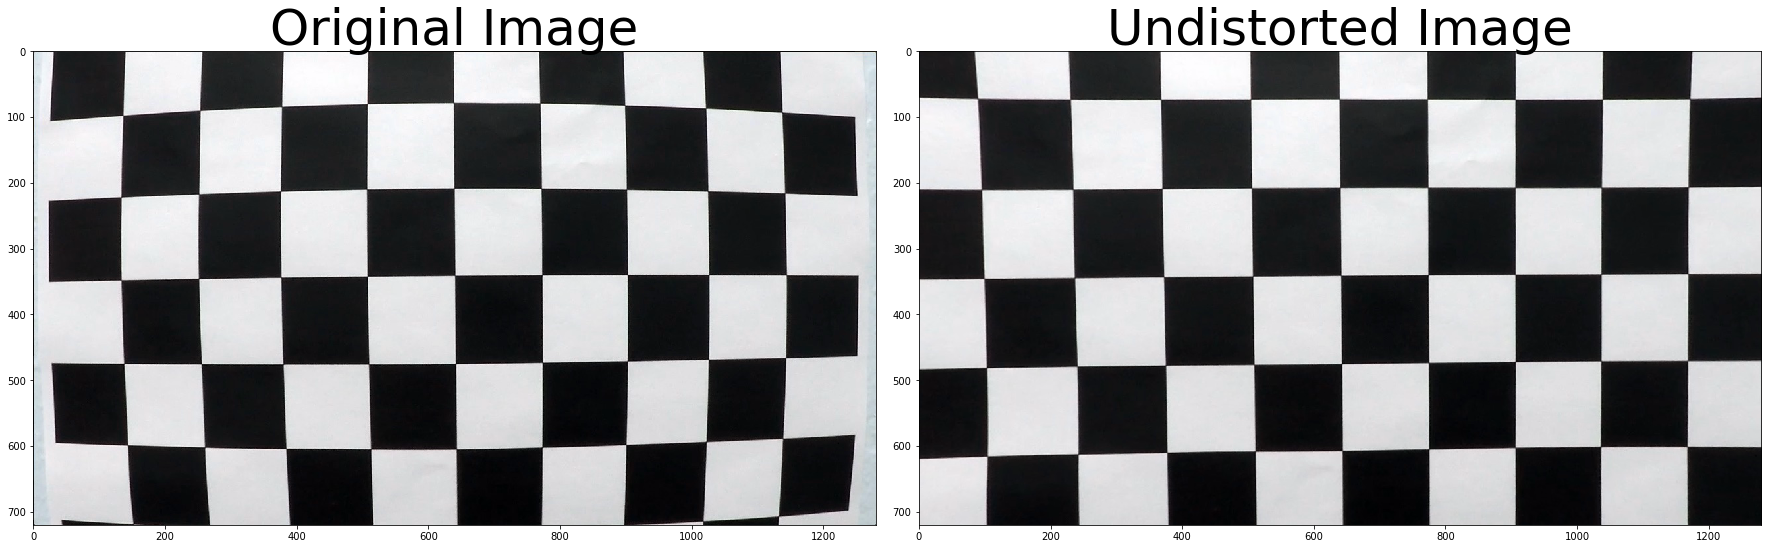

In [513]:
img = cv2.imread('camera_cal/calibration1.jpg')
#plt.imshow(img)

# Undistort method
def undistort_image(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dist = cv2.undistort(img, mtx, dist, None, mtx)
    return dist

undist = undistort_image(img, objpoints, imgpoints)
    
# Display images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Use color transforms, gradients, etc., to create a thresholded binary image.

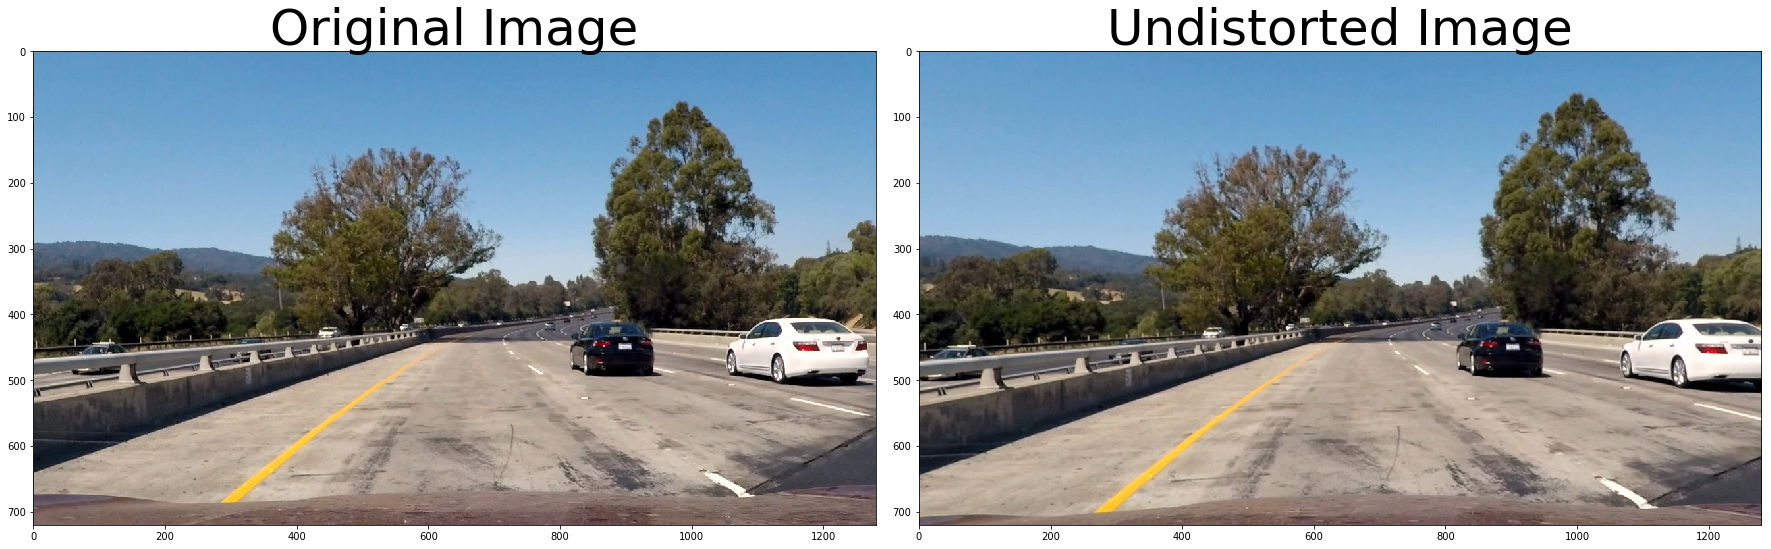

In [514]:
## Undisort test image.

# Here is not cv2.imread but mpimg.imread because cv2.imread will change image color.
test_img = mpimg.imread('./test_images/test1.jpg')

test_undist = undistort_image(test_img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

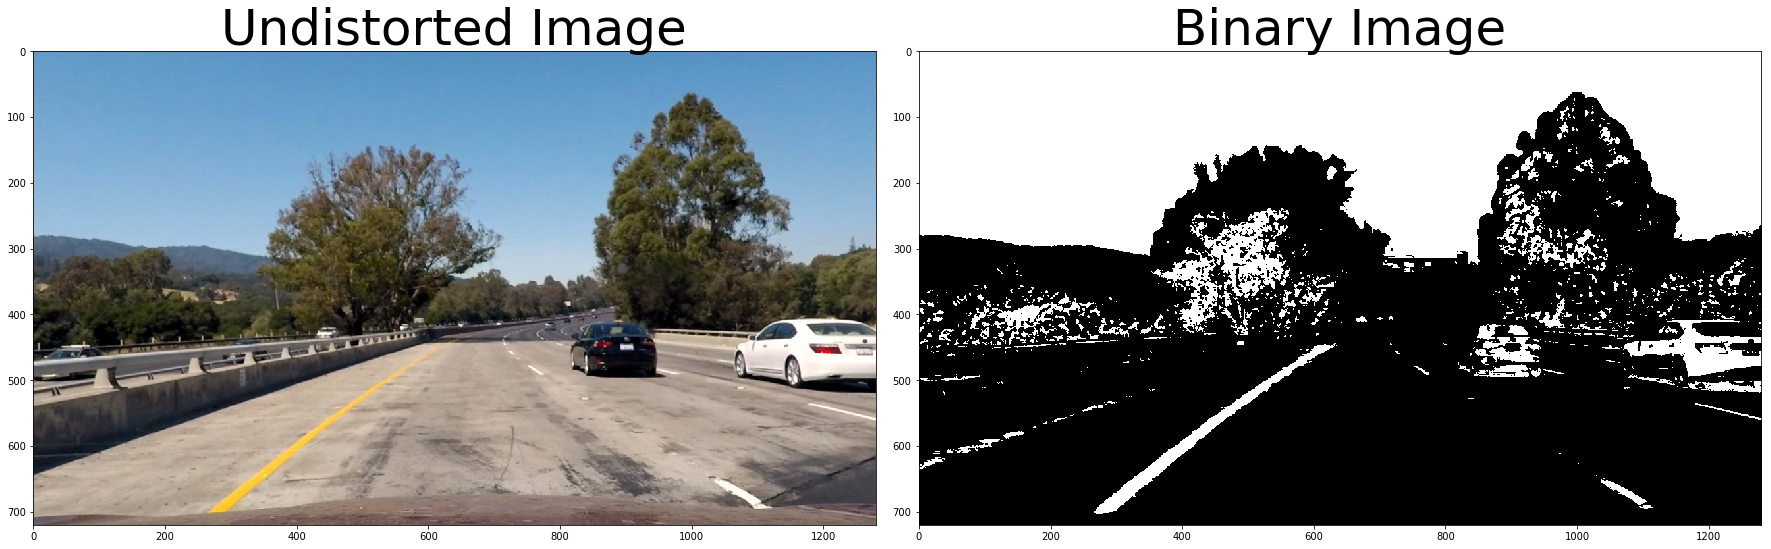

In [515]:
## Create binary image by using color transforms.

def hls_select(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

test_binary = hls_select(test_undist, thresh=(90, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_undist)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(test_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

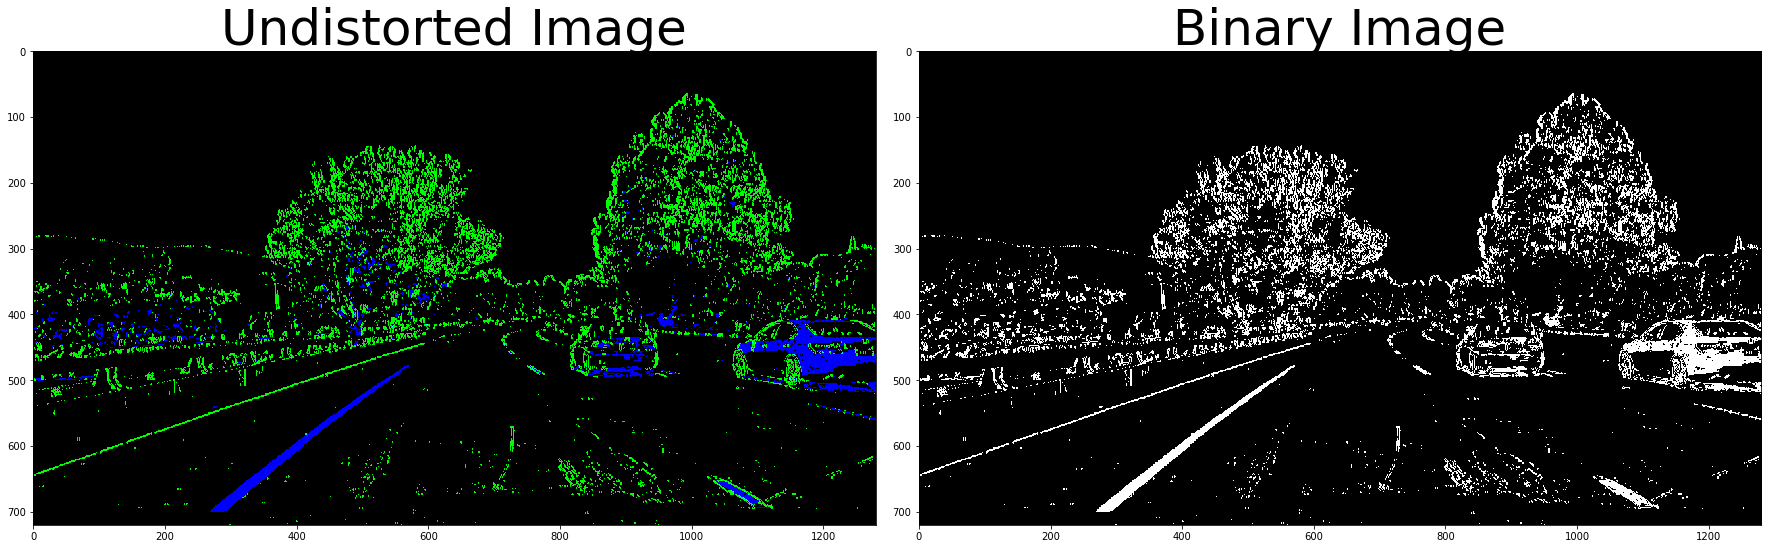

In [516]:
## Create binary image by using gradients.

def pipline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) |  (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

color_binary, combined_binary = pipline(test_undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Apply a perspective transform to rectify binary image ("birds-eye view").

In [517]:
"""
Unwarped image (birds-eye view) method. 
Using cv2.getPerspectiveTransform method
"""

def unwarp(img, src, dst):
    height, width = img.shape
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

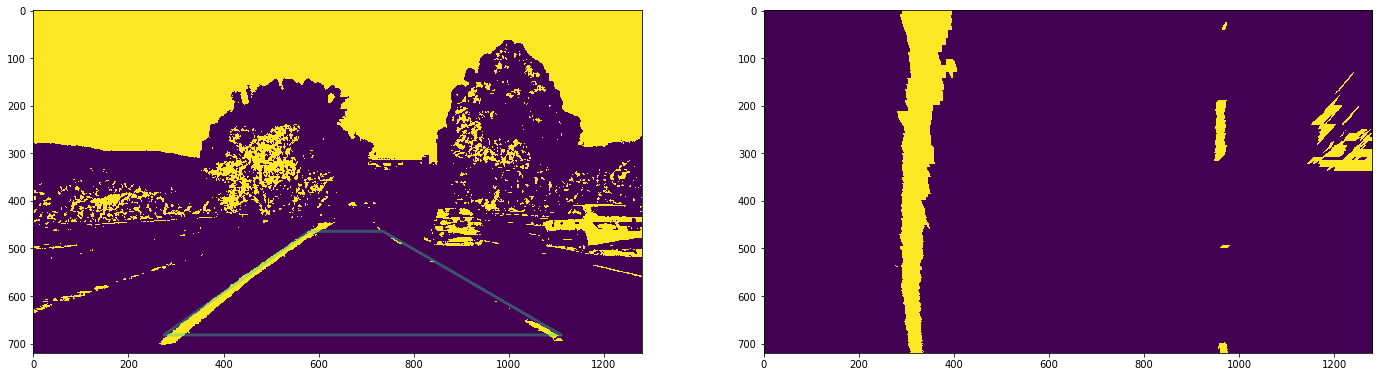

In [631]:
# Size settings
img_size = test_binary.shape
width = img_size[1]
height = img_size[0]
offset = 300

# Input image size
src = np.float32([
                  (580, 464),
                  (735, 464), 
                  (275, 682), 
                  (1110, 682)]
    )
# Output image size
dst = np.float32([
                  (offset,0),
                  (width-offset,0),
                  (offset,height),
                  (width-offset,height)]
    )

# Warped image
warped_image, M, Minv = unwarp(test_binary, src, dst)

# Display
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(test_binary)
x = [src[0][0], src[2][0], src[3][0], src[1][0],src[0][0]]
y = [src[0][1], src[2][1], src[3][1], src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.imshow(warped_image)

(720, 1280)
360
(1280,)


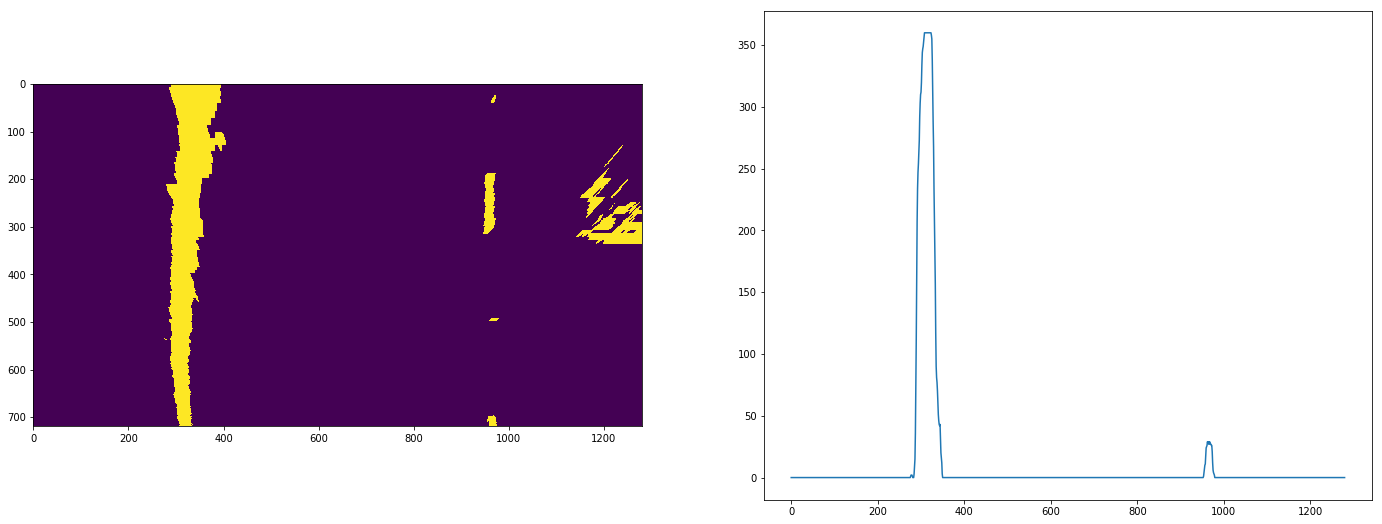

In [632]:
"""
Sum vertical value up. 
I first take a histogram along all the columns in the lower half( combined_binary.shape[0]//2 ) of the image like this:
If you want to sum value up each line, axis is 0.
"""

histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
print(warped_image.shape)
# At numpy, // means round down.
print(warped_image.shape[0]//2)
print(histogram.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(warped_image)
ax2.plot(histogram)

In [633]:
# windows settings
window_width = 100
window_height = 9  # Break image into 9 vertical layers since image height is 720
margin = 100  # How much to slide left and right for searching

# Window mask with hight limit
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[ \
           int(img_ref.shape[0]-(level+1)*height) : int(img_ref.shape[0]-level*height), \
           max(0, int(center-width/2)) : min(int(center+width/2), img_ref.shape[1])\
        ] = 1
    return output

# Slice image by window_width x window_height
def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = []  # Store the (left,right) window centroid positions per level
    window = np.ones(window_width)  # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):, :int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):, :int(image.shape[1]/2)], axis=0)
    r_center = np.argmax(np.convolve(window, r_sum)) - window_width/2 + int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center, r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(0, (int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin, 0))
        l_max_index = int(min(l_center+offset+margin, image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin, 0))
        r_max_index = int(min(r_center+offset+margin, image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))
    
    return window_centroids

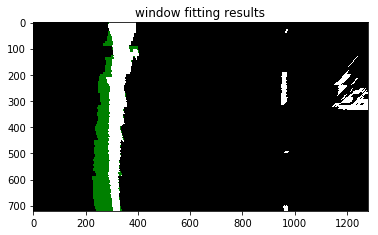

In [634]:
window_centroids = find_window_centroids(warped_image, window_width, window_height, margin)
warped = warped_image

# If we found any window centers
if len(window_centroids) > 0:
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    # Go through each level and draw the windows 	
    for level in range(0, len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
        r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1))] =255
        r_points[(r_points == 255 | ((r_mask == 1)))] = 255

    # Draw the results
    template = np.array(r_points + l_points, np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8) # make window pixels green
    warpage = np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped, warped, warped)), np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

# Detect lane pixels and fit to find the lane boundary.

* leftx_base, rightx_base: Image width divided by 4, 1st quater is leftx_base and 3rd quater is rightx_base
* good_left_inds, good_right_inds: None zero value index in window
* left_lane_inds, right_lane_inds: None zero value index in all windows
* leftx_current, rightx_current: If minimum size of pixels is in window, it is updated average of index value
* left_lane_inds, right_lane_inds: 1D array of left_lane_inds, right_lane_inds
* leftx, rightx: None zero value index for x axis
* lefty, righty: None zero value index for y axis
* left_fit, right_fit: Result of regression from (leftx, lefty) and (rightx, righty)
* ploty: Evenly spaced numbers over a specified interval from 0 to image height
* left_fitx, left_fity, right_fix, right_fity: x and y values for plotting generated by left_fit or right_fit

In [635]:
def polynominal(image, display_image=True):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histgram = np.sum(image[image.shape[0]//2:, :], axis=0)
    # Create an output image to draw on and  visualize the result
    # np.dstack help stacking array
    out_img = np.dstack((image, image, image)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # np.argmax detect indices of values.
    midpoint = np.int(histgram.shape[0]/2)
    leftx_base = np.argmax(histgram[:midpoint])
    rightx_base = np.argmax(histgram[:midpoint]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # np.nonzero() returns indices of not zero value
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        # cv2.rectangle can draw rectangle. cv2.rectangle(image, point of top left, point of below right, color, line width)
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int((np.mean(nonzerox[good_left_inds])))
        if len(good_right_inds) > minpix:
            rightx_current = np.int((np.mean(nonzerox[good_right_inds])))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzeroy[right_lane_inds]] = [0, 0, 255]
    if display_image == True: 
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    #For Video:
    LEFT.recent_xfits = [(left_fitx)]
    LEFT.best_xfit = np.mean(LEFT.recent_xfits)
    RIGHT.recent_xfits = [(right_fitx)]
    RIGHT.best_xfit = np.mean(RIGHT.recent_xfits)
        
    LEFT.current_fit_coeffs = [(left_fit)]
    LEFT.best_fit_coeffs = np.mean(LEFT.current_fit_coeffs)
    RIGHT.current_fit_coeffs = [(right_fit)]
    RIGHT.best_fit_coeffs = np.mean(RIGHT.current_fit_coeffs)
    
    LEFT.line_base_position = leftx_current
    RIGHT.line_base_position = rightx_current
    
    LEFT.allx = leftx
    LEFT.ally = lefty
    RIGHT.allx = rightx
    RIGHT.ally = righty
    
    datus = {}
    datus['windows_img'] = out_img
    datus['ploty'] = ploty
    datus['left_fitx'] = left_fitx
    datus['right_fitx'] = right_fitx

    datus['left_fit'] = left_fit
    datus['right_fit'] = right_fit
    datus['leftx'] = leftx
    datus['rightx'] = rightx
    datus['leftx_base'] = leftx_base
    datus['rightx_base'] = rightx_base

    
    return datus

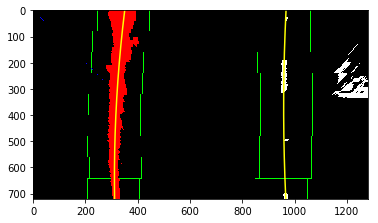

In [636]:
datus = polynominal(warped_image)

# Determine the curvature of the lane and vehicle position with respect to center.

In [637]:
def sliding_window(image, display_image=True):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    datus = polynominal(warped_image, False)
    left_fit = datus['left_fit']
    right_fit = datus['right_fit']
    leftx_base  = datus['leftx_base']
    rightx_base  = datus['rightx_base']
    
    left_lane_indexs = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_indexs = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_indexs]
    lefty = nonzeroy[left_lane_indexs]
    rightx = nonzerox[right_lane_indexs]
    righty = nonzeroy[right_lane_indexs]
    
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((image, image, image))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_indexs], nonzerox[left_lane_indexs]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_indexs], nonzerox[right_lane_indexs]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])    
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    if display_image == True: 
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    if display_image == True: 
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    new_datus = {}
    new_datus['window_img'] = out_img
    new_datus['ploty'] = ploty
    new_datus['left_fitx'] = left_fitx
    new_datus['right_fitx'] = right_fitx
    
    new_datus['left_fit'] = left_fit
    new_datus['right_fit'] = right_fit
    new_datus['leftx'] = leftx
    new_datus['rightx'] = rightx
    new_datus['leftx_base'] = leftx_base
    new_datus['rightx_base'] = rightx_base
    return result, new_datus

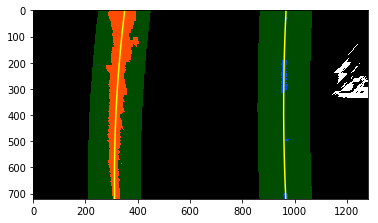

In [638]:
_, draw_status = sliding_window(warped_image)

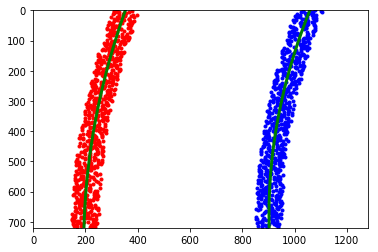

In [639]:
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
ploty =  draw_status['ploty']
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

## Radius of Curvature


* sample site 
  * https://www.intmath.com/applications-differentiation/8-radius-curvature.php
  * http://mathworld.wolfram.com/RadiusofCurvature.html

In [640]:
def roc_in_pixels(ploty, left_fit, right_fit, leftx, rightx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)

In [641]:
roc_in_pixels(datus['ploty'], datus['left_fit'], datus['right_fit'], datus['leftx'], datus['rightx'])

5210.807337738589 7524.631100182142


In [642]:
def roc_in_meters(ploty, left_fitx, right_fitx, leftx, rightx, display_roc=True):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #For Video:
    LEFT.radius_of_curvature = left_curverad
    RIGHT.radius_of_curvature = right_curverad

    # Now our radius of curvature is in meters
    if display_roc == True:  print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad

In [643]:
roc_in_meters(datus['ploty'], datus['left_fit'], datus['right_fit'], datus['left_fitx'], datus['right_fitx'])

1710.9167790572933 m 2463.611045605604 m


(1710.9167790572933, 2463.611045605604)

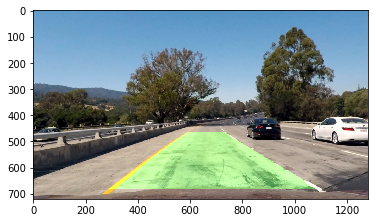

In [644]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([draw_status['left_fitx'], ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([draw_status['right_fitx'], draw_status['ploty']])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (test_img.shape[1], test_img.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(test_undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [645]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # last lane base position
        self.recent_basex = None

In [646]:
def offset(img_center, leftx_base, rightx_base):
    poly_center = (leftx_base + rightx_base) / 2
    diff_pix = img_center - poly_center
    xm_per_pix = 3.5/1000
    offset = diff_pix * xm_per_pix
    return offset

In [647]:
"""
# About np.flipud

>>> A = np.diag([1.0, 2, 3])
>>> A
array([[ 1.,  0.,  0.],
       [ 0.,  2.,  0.],
       [ 0.,  0.,  3.]])
>>> np.flipud(A)
array([[ 0.,  0.,  3.],
       [ 0.,  2.,  0.],
       [ 1.,  0.,  0.]])
"""


def lane_mapping(img_shape, warped, Minv, ploty, left_fitx, right_fitx, undistorted):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0)) 
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_shape[1], img_shape[0])) 
    out_img = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return out_img

In [648]:
def annotate(img, left_curverad, right_curverad, camera):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(img, 'Left Radius of Curvature: {0:6f} meters'.format(left_curverad), (10,30), font, 1, (255,255,255), 2)
    cv2.putText(img, 'Right Radius of Curvature: {0:6f} meters'.format(right_curverad),(10,60), font, 1, (255,255,255), 2)
    cv2.putText(img, 'Camera Offset: {0:6f} meters'.format(camera), (10,90), font, 1, (255,255,255), 2)

In [659]:
def process_image(img):
        
    undistorted = undistort_image(img, objpoints, imgpoints)
    _, binary_thresholded = pipline(undistorted)
    warped, M, Minv = unwarp(binary_thresholded, src, dst)
    _, datus = sliding_window(warped, False)
    windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx, leftx_base, rightx_base = datus['window_img'], datus['ploty'], datus['left_fitx'], datus['right_fitx'], datus['left_fit'], datus['right_fit'], datus['leftx'], datus['rightx'], datus['leftx_base'], datus['rightx_base']
    left_curverad, right_curverad = roc_in_meters(ploty, left_fit, right_fit, left_fitx, right_fitx, False)

    #####  Start Line class instance #####

    # LEFT
    if left_curverad < 800 and LEFT.detected == True:
        left_fitx = LEFT.recent_xfitted
        leftx_base = LEFT.recent_basex
        left_curverad = LEFT.radius_of_curvature
    else:
        LEFT.detected = True
        LEFT.recent_xfitted = left_fitx
        LEFT.recent_basex = leftx_base
        LEFT.radius_of_curvature = left_curverad

    # RIGHT
    if right_curverad < 800 and RIGHT.detected == True:
        right_fitx = RIGHT.recent_xfitted
        rightx_base = RIGHT.recent_basex
        right_curverad = RIGHT.radius_of_curvature
    else:
        RIGHT.detected = True
        RIGHT.recent_xfitted = right_fitx
        RIGHT.recent_basex = rightx_base
        RIGHT.radius_of_curvature = right_curverad
    
    #####  End Line class instance #####
    
    camera = offset(img.shape[1]/2, leftx_base, rightx_base)
    out_img = lane_mapping(img.shape[:2], warped, Minv, ploty, left_fitx, right_fitx, undistorted)
    annotate(out_img, left_curverad, right_curverad, camera)    
    return out_img

Text(0.5,1,'Test 1 Output:')

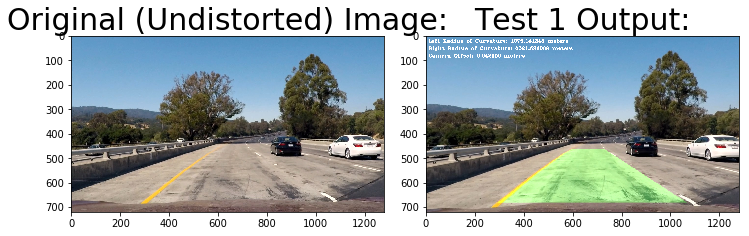

In [662]:
LEFT = Line()
RIGHT = Line()

img = cv2.imread('test_images/test1.jpg')
out_img = process_image(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original (Undistorted) Image:', fontsize=30)
ax2.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB), cmap='gray')
ax2.set_title('Test 1 Output:', fontsize=30)

In [661]:
LEFT = Line()
RIGHT = Line()

video_output1 = 'project_video_output.mp4'
# https://zulko.github.io/moviepy/ref/VideoClip/VideoClip.html
# fl_image(image_func, apply_to=[])
# Modifies the images of a clip by replacing the frame get_frame(t) by another frame, image_func(get_frame(t))
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:00<00:00,  4.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 11s, sys: 54.6 s, total: 9min 5s
Wall time: 5min 1s
